In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter # Useful for various plotting, though not strictly for ER here
import re # For regular expressions in cleaning

# --- Helper Function to Calculate Engagement Rate ---
def calculate_engagement_rate(row, sub_col_name, likes_col_name, comments_col_name, shares_col_name=None):
    """
    Calculates a simplified engagement rate based on average interactions per post/video.
    Formula: (Average Likes + Average Comments + Average Shares) / Subscribers * 100
    Handles potential NaN values for interaction metrics (treats as 0) and division by zero subscribers.

    Args:
        row (pd.Series): A row from the DataFrame.
        sub_col_name (str): The actual column name for subscribers/followers.
        likes_col_name (str): The actual column name for average likes.
        comments_col_name (str): The actual column name for average comments.
        shares_col_name (str, optional): The actual column name for average shares (e.g., for TikTok). Defaults to None.

    Returns:
        float: The calculated engagement rate as a percentage, or NaN if calculation is not possible.
    """
    subscribers = row.get(sub_col_name)
    likes = row.get(likes_col_name, 0)
    comments = row.get(comments_col_name, 0)
    shares = row.get(shares_col_name, 0) if shares_col_name else 0

    # Ensure numeric and handle NaNs for calculation
    subscribers = pd.to_numeric(subscribers, errors='coerce')
    likes = pd.to_numeric(likes, errors='coerce')
    comments = pd.to_numeric(comments, errors='coerce')
    shares = pd.to_numeric(shares, errors='coerce')

    likes = 0 if pd.isna(likes) else likes
    comments = 0 if pd.isna(comments) else comments
    shares = 0 if pd.isna(shares) else shares

    if pd.isna(subscribers) or subscribers == 0:
        return np.nan # Cannot calculate ER without valid subscriber count

    total_interactions = likes + comments + shares

    return (total_interactions / subscribers) * 100

# --- Main Analysis Function for Engagement Rate ---
def analyze_engagement_rate(insta_df, tiktok_df, youtube_df,
                            insta_col_map={'subscribers': 'subscribers', 'likes_avg': 'likes_avg', 'comments_avg': 'comments_avg'},
                            tiktok_col_map={'subscribers': 'subscribers', 'likes_avg': 'likes_avg', 'comments_avg': 'comments_avg', 'shares_avg': 'shares_avg'},
                            yt_col_map={'subscribers': 'subscribers', 'likes_avg': 'avg_likes', 'comments_avg': 'avg_comments'}):
    """
    Calculates and visualizes engagement rates for influencers on Instagram, TikTok, and YouTube.

    Args:
        insta_df (pd.DataFrame): DataFrame containing Instagram influencer data.
        tiktok_df (pd.DataFrame): DataFrame containing TikTok influencer data.
        youtube_df (pd.DataFrame): DataFrame containing YouTube influencer data.
        insta_col_map (dict): Dictionary mapping generic metric names (keys) to actual column names (values) for Instagram.
        tiktok_col_map (dict): Dictionary mapping generic metric names to actual column names for TikTok.
        yt_col_map (dict): Dictionary mapping generic metric names to actual column names for YouTube.
    """
    print("--- Starting Engagement Rate Analysis ---")

    all_engagement_data = [] # To store engagement rates for all platforms

    # Define configurations for each platform
    platforms_config = {
        'Instagram': {'df': insta_df, 'col_map': insta_col_map, 'include_shares': False},
        'TikTok':    {'df': tiktok_df, 'col_map': tiktok_col_map, 'include_shares': True},
        'YouTube':   {'df': youtube_df, 'col_map': yt_col_map, 'include_shares': False}
    }

    for platform_name, config in platforms_config.items():
        df = config['df']
        col_map = config['col_map']
        include_shares = config['include_shares']

        if df is None:
            print(f"\nSkipping {platform_name}: DataFrame is None (check file path).")
            continue

        # Get actual column names from the mapping
        sub_col = col_map.get('subscribers')
        likes_col = col_map.get('likes_avg')
        comments_col = col_map.get('comments_avg')
        shares_col = col_map.get('shares_avg') if include_shares else None

        # Check if all absolutely required columns exist in the DataFrame
        required_present_cols = [col for col in [sub_col, likes_col, comments_col] if col is not None and col in df.columns]
        expected_required_cols_count = 3 # subscribers, likes_avg, comments_avg

        if len(required_present_cols) < expected_required_cols_count:
            missing_for_platform = [col for col in [sub_col, likes_col, comments_col] if col not in df.columns]
            print(f"\nSkipping {platform_name}: Missing one or more required columns for ER calculation: {missing_for_platform} or mapping is incorrect.")
            continue

        # Prepare DataFrame for calculation: select only necessary columns
        cols_for_calc = [sub_col, likes_col, comments_col]
        if shares_col and shares_col in df.columns:
            cols_for_calc.append(shares_col)
        else:
            shares_col = None # Ensure it's None if not present/mapped for this platform

        df_for_er = df[cols_for_calc].copy()

        # Calculate engagement rate using the helper function
        df_for_er['engagement_rate'] = df_for_er.apply(
            lambda row: calculate_engagement_rate(row, sub_col, likes_col, comments_col, shares_col),
            axis=1
        )

        # Add platform column and append to overall list
        df_for_er['platform'] = platform_name
        valid_er_data = df_for_er.dropna(subset=['engagement_rate'])

        if not valid_er_data.empty:
            all_engagement_data.append(valid_er_data[['engagement_rate', 'platform']])
            print(f"\n--- {platform_name} Engagement Rate Summary ({valid_er_data.shape[0]} valid entries) ---")
            print(valid_er_data['engagement_rate'].describe().to_string())
        else:
            print(f"\nNo valid engagement rate data for {platform_name} after calculation and cleaning.")


    # --- Combined Engagement Rate Visualizations ---
    if all_engagement_data:
        combined_er_df = pd.concat(all_engagement_data, ignore_index=True)

        if not combined_er_df.empty:
            print("\n--- Visualizing Engagement Rates Across Platforms ---")

            # --- Box Plot of Engagement Rate Distribution ---
            plt.figure(figsize=(10, 7))
            sns.boxplot(x='platform', y='engagement_rate', data=combined_er_df, palette='viridis')
            plt.title('Engagement Rate Distribution Across Platforms')
            plt.xlabel('Platform')
            plt.ylabel('Engagement Rate (%)')
            # Set y-axis limit to focus on the majority of data, ignoring extreme outliers
            # You can adjust the percentile (e.g., 0.995) or multiplier (e.g., 1.5) as needed
            plt.ylim(0, combined_er_df['engagement_rate'].quantile(0.99) * 1.2)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

            # --- Violin Plot of Engagement Rate Distribution ---
            plt.figure(figsize=(10, 7))
            sns.violinplot(x='platform', y='engagement_rate', data=combined_er_df, palette='viridis')
            plt.title('Detailed Engagement Rate Distribution Across Platforms')
            plt.xlabel('Platform')
            plt.ylabel('Engagement Rate (%)')
            plt.ylim(0, combined_er_df['engagement_rate'].quantile(0.99) * 1.2) # Apply same limit
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

            # --- Bar Plot of Average Engagement Rate ---
            plt.figure(figsize=(9, 6))
            avg_er = combined_er_df.groupby('platform')['engagement_rate'].mean().sort_values(ascending=False)
            sns.barplot(x=avg_er.index, y=avg_er.values, palette='coolwarm')
            plt.title('Average Engagement Rate by Platform')
            plt.xlabel('Platform')
            plt.ylabel('Average Engagement Rate (%)')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

        else:
            print("No valid engagement rate data could be consolidated for visualization. Please check data and column mappings.")
    else:
        print("No engagement rate data could be processed for any platform. Check input DataFrames and column mappings.")

    print("\n--- Engagement Rate Analysis Complete ---")


# --- EXAMPLE DATA LOADING (REPLACE WITH YOUR ACTUAL DATA) ---
# IMPORTANT:
# 1. Place your CSV files in the same directory as this Python script,
#    OR provide the full path to your files (e.g., 'C:/Users/YourUser/Desktop/instagram_data.csv').
# 2. ENSURE THE '.csv' EXTENSION IS CORRECT (e.g., '.xlsx' if it's an Excel file).

try:
    # Ensure these columns exist in your Instagram data
    insta_df = pd.read_csv('./Clean_Data/merged_instagram_data_cleaned.csv')
    print("Instagram data loaded.")
except FileNotFoundError:
    print("instagram_data.csv not found. Please check the file path.")
    insta_df = None

try:
    # Ensure these columns exist in your TikTok data
    tiktok_df = pd.read_csv('./Clean_Data/merged_tiktok_data_cleaned.csv')
    print("TikTok data loaded.")
except FileNotFoundError:
    print("tiktok_data.csv not found. Please check the file path.")
    tiktok_df = None

try:
    # Ensure these columns exist in your YouTube data
    youtube_df = pd.read_csv('./Clean_Data/merged_youtube_data_cleaned.csv')
    print("YouTube data loaded.")
except FileNotFoundError:
    print("youtube_data.csv not found. Please check the file path.")
    youtube_df = None


# --- CALL THE ENGAGEMENT RATE ANALYSIS FUNCTION ---
# VERY IMPORTANT:
# Adjust the column names in the dictionaries below to EXACTLY match the column
# headers in YOUR specific CSV files.
#
# Common column name examples:
# - Subscribers: 'subscribers', 'followers', 'audience_size'
# - Average Likes: 'likes_avg', 'average_likes_per_post', 'avg_hearts'
# - Average Comments: 'comments_avg', 'average_comments_per_post'
# - Average Shares: 'shares_avg', 'average_shares_per_post' (primarily for TikTok)

analyze_engagement_rate(
    insta_df=insta_df,
    tiktok_df=tiktok_df,
    youtube_df=youtube_df,
    # --- Instagram Column Mappings ---
    insta_col_map={
        'subscribers': 'subscribers',   # <--- Change this if your Instagram subscriber column is different
        'likes_avg': 'likes_avg',       # <--- Change this if your Instagram avg likes column is different
        'comments_avg': 'comments_avg'  # <--- Change this if your Instagram avg comments column is different
    },
    # --- TikTok Column Mappings ---
    tiktok_col_map={
        'subscribers': 'subscribers',   # <--- Change this if your TikTok subscriber column is different
        'likes_avg': 'likes_avg',       # <--- Change this if your TikTok avg likes column is different
        'comments_avg': 'comments_avg', # <--- Change this if your TikTok avg comments column is different
        'shares_avg': 'shares_avg'      # <--- Change this if your TikTok avg shares column is different (set to None in func call if not present)
    },
    # --- YouTube Column Mappings ---
    yt_col_map={
        'subscribers': 'subscribers',   # <--- Change this if your YouTube subscriber column is different
        'likes_avg': 'avg_likes',       # <--- Change this if your YouTube avg likes column is different (e.g., 'likes_per_video')
        'comments_avg': 'avg_comments'  # <--- Change this if your YouTube avg comments column is different (e.g., 'comments_per_video')
    }
)

Instagram data loaded.
TikTok data loaded.
YouTube data loaded.
--- Starting Engagement Rate Analysis ---

No valid engagement rate data for Instagram after calculation and cleaning.

No valid engagement rate data for TikTok after calculation and cleaning.

No valid engagement rate data for YouTube after calculation and cleaning.
No engagement rate data could be processed for any platform. Check input DataFrames and column mappings.

--- Engagement Rate Analysis Complete ---


In [2]:
# --- Helper Function for Data Inspection (Add this to your script) ---
def inspect_dataframe_for_engagement_rate(df, platform_name, col_map):
    """
    Helps inspect a DataFrame for common issues preventing engagement rate calculation.
    """
    print(f"\n--- INSPECTING {platform_name} DataFrame ---")
    if df is None:
        print(f"DataFrame for {platform_name} is None. Cannot inspect.")
        return

    print("\n--- First 5 rows of DataFrame ---")
    print(df.head().to_string()) # Use .to_string() for better console display

    print("\n--- DataFrame Info (Column Names & Data Types) ---")
    df.info()

    print("\n--- Checking Specific Columns for Engagement Rate Calculation ---")
    sub_col = col_map.get('subscribers')
    likes_col = col_map.get('likes_avg')
    comments_col = col_map.get('comments_avg')
    shares_col = col_map.get('shares_avg') # May be None

    columns_to_check = {
        'subscribers': sub_col,
        'likes_avg': likes_col,
        'comments_avg': comments_col,
        'shares_avg': shares_col # Only if it's expected for this platform
    }

    actual_present_cols = []
    print(f"Expected Column Mappings for {platform_name}:")
    for generic_name, actual_name in columns_to_check.items():
        if actual_name: # Only check if a column name was provided in the map
            print(f"  - {generic_name} expects actual column: '{actual_name}'")
            if actual_name in df.columns:
                print(f"    - '{actual_name}' FOUND in DataFrame columns.")
                actual_present_cols.append(actual_name)
                # Check for non-numeric values
                original_count = df[actual_name].shape[0]
                numeric_series = pd.to_numeric(df[actual_name], errors='coerce')
                nan_count = numeric_series.isna().sum()
                print(f"    - '{actual_name}' has {nan_count} non-numeric/missing values out of {original_count} total.")
                if nan_count > 0 and nan_count == original_count:
                    print(f"      CRITICAL: All values in '{actual_name}' are non-numeric/missing. This column will be entirely NaN after conversion.")
                elif nan_count > 0:
                     print(f"      WARNING: Some values in '{actual_name}' are non-numeric/missing. Inspect these rows.")

            else:
                print(f"    - CRITICAL: Column '{actual_name}' (for {generic_name}) NOT FOUND in DataFrame columns. Please check your mapping.")
        else:
            print(f"  - No mapping provided for {generic_name}.")

    if not actual_present_cols:
        print(f"\nNo relevant engagement rate columns found for {platform_name}. Double-check your `col_map` and DataFrame headers.")


# --- Place this section in your existing script ---
# After your try-except blocks for loading insta_df, tiktok_df, youtube_df
# and BEFORE the call to analyze_engagement_rate(...)

# --- Data Inspection Calls ---
# IMPORTANT: Use the SAME col_map dictionaries you use in the analyze_engagement_rate function call.
print("\n===== Running Data Inspection =====")
inspect_dataframe_for_engagement_rate(insta_df, 'Instagram', {
    'subscribers': 'subscribers',
    'likes_avg': 'likes_avg',
    'comments_avg': 'comments_avg'
})
inspect_dataframe_for_engagement_rate(tiktok_df, 'TikTok', {
    'subscribers': 'subscribers',
    'likes_avg': 'likes_avg',
    'comments_avg': 'comments_avg',
    'shares_avg': 'shares_avg'
})
inspect_dataframe_for_engagement_rate(youtube_df, 'YouTube', {
    'subscribers': 'subscribers',
    'likes_avg': 'avg_likes',
    'comments_avg': 'avg_comments'
})
print("\n===== Data Inspection Complete =====")

# --- Your existing analyze_engagement_rate() call will go here ---
# analyze_engagement_rate(...)


===== Running Data Inspection =====

--- INSPECTING Instagram DataFrame ---

--- First 5 rows of DataFrame ---
   sno instagram_name               name  subscribers audience_country authentic_engagement engagement_average                 category_1 category_2 influencer_insta_name audience_country(mostly) engagement_avg   rank eng_(auth) eng_(avg) country influencer_name subscribers_count views_avg likes_avg comments_avg
0  1.0      cristiano  Cristiano Ronaldo            0            India                   5M               6.2M         Sports with a ball    Unknown                   NaN                      NaN            NaN  499.0        NaN       NaN     NaN             NaN               NaN       NaN       NaN          NaN
1  2.0    kyliejenner            Kylie 🤍            0    United States                 3.5M               5.5M                    Fashion   Modeling                   NaN                      NaN            NaN  499.0        NaN       NaN     NaN             N

In [3]:
# --- Helper Function for Cleaning Numeric Columns (Handles 'K', 'M' suffixes) ---
def clean_numeric_column(series):
    """
    Cleans a pandas Series by converting values with 'K' or 'M' suffixes to numeric.
    Handles NaNs and non-numeric values by coercing them to NaN.
    """
    if not pd.api.types.is_numeric_dtype(series):
        # Convert to string to apply string operations
        s = series.astype(str).str.strip().str.upper()

        # Define conversion function
        def convert_value(value):
            if pd.isna(value) or value == 'NAN' or not value:
                return np.nan
            value = value.replace(',', '') # Remove commas
            if 'M' in value:
                return float(value.replace('M', '')) * 1_000_000
            elif 'K' in value:
                return float(value.replace('K', '')) * 1_000
            else:
                return pd.to_numeric(value, errors='coerce') # Convert remaining to numeric

        return s.apply(convert_value)
    else:
        return pd.to_numeric(series, errors='coerce') # Ensure it's numeric even if already numeric type

# --- Helper Function to Calculate Engagement Rate ---
def calculate_engagement_rate(row, sub_col_name, likes_col_name, comments_col_name, shares_col_name=None):
    """
    Calculates a simplified engagement rate.
    Formula: (Average Likes + Average Comments + Average Shares) / Subscribers * 100
    Handles potential NaN values and division by zero.
    """
    subscribers = row.get(sub_col_name)
    likes = row.get(likes_col_name, 0)
    comments = row.get(comments_col_name, 0)
    shares = row.get(shares_col_name, 0) if shares_col_name else 0

    # Ensure values are float after cleaning (which happens before this function call)
    likes = 0 if pd.isna(likes) else float(likes)
    comments = 0 if pd.isna(comments) else float(comments)
    shares = 0 if pd.isna(shares) else float(shares)
    subscribers = pd.to_numeric(subscribers, errors='coerce') # Ensure numeric after potential K/M cleaning

    if pd.isna(subscribers) or subscribers == 0:
        return np.nan # Cannot calculate ER without valid subscriber count

    total_interactions = likes + comments + shares

    return (total_interactions / subscribers) * 100

# --- Main Analysis Function for Content Niche Performance ---
def analyze_content_niche_performance(
    insta_df, tiktok_df, youtube_df,
    target_categories=['Sports with a ball', 'Fashion'], # <--- EDIT THIS LIST with your categories
    insta_col_map={
        'category': 'category_1', # <--- Update if your category column is different
        'subscribers': 'subscribers',
        'likes_avg': 'authentic_engagement', # <--- Update to your actual avg likes/engagement column
        'comments_avg': 'engagement_average'  # <--- Update to your actual avg comments/engagement column
    },
    tiktok_col_map={
        'category': 'category_1', # <--- Update if your category column is different
        'subscribers': 'subscribers',
        'likes_avg': 'likes_avg', # <--- Update to your actual avg likes column
        'comments_avg': 'comments_avg', # <--- Update to your actual avg comments column
        'shares_avg': 'shares_avg' # <--- Update to your actual avg shares column (or remove if not applicable)
    },
    yt_col_map={
        'category': 'category', # <--- Update if your category column is different
        'subscribers': 'subscribers',
        'likes_avg': 'avg_likes', # <--- Update to your actual avg likes column
        'comments_avg': 'avg_comments' # <--- Update to your actual avg comments column
    }
):
    """
    Analyzes and visualizes performance of influencers within specified content niches across platforms.

    Args:
        insta_df (pd.DataFrame): Instagram DataFrame.
        tiktok_df (pd.DataFrame): TikTok DataFrame.
        youtube_df (pd.DataFrame): YouTube DataFrame.
        target_categories (list): A list of content categories to analyze (e.g., ['Gaming', 'Beauty']).
        insta_col_map (dict): Mapping of generic names to actual column names for Instagram.
        tiktok_col_map (dict): Mapping for TikTok.
        yt_col_map (dict): Mapping for YouTube.
    """
    print(f"--- Starting Content Niche Performance Deep Dive for: {target_categories} ---")

    all_niche_data = []

    platforms_config = {
        'Instagram': {'df': insta_df, 'col_map': insta_col_map, 'has_shares': False},
        'TikTok':    {'df': tiktok_df, 'col_map': tiktok_col_map, 'has_shares': True},
        'YouTube':   {'df': youtube_df, 'col_map': yt_col_map, 'has_shares': False}
    }

    for platform_name, config in platforms_config.items():
        df = config['df']
        col_map = config['col_map']
        has_shares = config['has_shares']

        if df is None:
            print(f"\nSkipping {platform_name}: DataFrame is None.")
            continue

        # Get actual column names from the mapping
        category_col = col_map.get('category')
        sub_col = col_map.get('subscribers')
        likes_col = col_map.get('likes_avg')
        comments_col = col_map.get('comments_avg')
        shares_col = col_map.get('shares_avg') if has_shares else None

        # Check for existence of essential columns
        essential_cols = [category_col, sub_col, likes_col, comments_col]
        if shares_col: essential_cols.append(shares_col)
        missing_cols = [col for col in essential_cols if col is None or col not in df.columns]

        if missing_cols:
            print(f"\nSkipping {platform_name}: Missing essential columns for niche analysis: {missing_cols}. Please check your column mappings.")
            continue

        # --- Data Cleaning for Numeric Columns ---
        df_cleaned = df.copy()
        df_cleaned[sub_col] = clean_numeric_column(df_cleaned[sub_col])
        df_cleaned[likes_col] = clean_numeric_column(df_cleaned[likes_col])
        df_cleaned[comments_col] = clean_numeric_column(df_cleaned[comments_col])
        if shares_col:
            df_cleaned[shares_col] = clean_numeric_column(df_cleaned[shares_col])

        # Filter for target categories
        # Ensure category column is string type for proper comparison
        df_cleaned[category_col] = df_cleaned[category_col].astype(str).str.strip()
        df_niche = df_cleaned[df_cleaned[category_col].isin(target_categories)].copy()

        if df_niche.empty:
            print(f"No influencers found for target categories {target_categories} on {platform_name}. Skipping.")
            continue

        # Calculate Engagement Rate for the niche
        df_niche['engagement_rate'] = df_niche.apply(
            lambda row: calculate_engagement_rate(row, sub_col, likes_col, comments_col, shares_col),
            axis=1
        )
        df_niche['platform'] = platform_name

        # Append valid niche data
        valid_niche_data = df_niche.dropna(subset=[sub_col, 'engagement_rate'])
        if not valid_niche_data.empty:
            all_niche_data.append(valid_niche_data[[sub_col, 'engagement_rate', 'platform', category_col]])
            print(f"\n--- {platform_name} Niche Performance Summary (Category: {target_categories}) ---")
            print(f"Average Subscribers: {valid_niche_data[sub_col].mean():,.0f}")
            print(f"Average Engagement Rate: {valid_niche_data['engagement_rate'].mean():.2f}%")
            print("\nTop 5 Influencers in Niche:")
            print(valid_niche_data.sort_values(by=sub_col, ascending=False).head(5)[['name', sub_col, 'engagement_rate']].to_string(index=False))
        else:
            print(f"No valid niche performance data for {platform_name} after cleaning and ER calculation.")

    # --- Combined Niche Performance Visualization ---
    if all_niche_data:
        combined_niche_df = pd.concat(all_niche_data, ignore_index=True)

        if not combined_niche_df.empty:
            print("\n--- Visualizing Niche Performance Across Platforms ---")

            # Group by platform and category for plotting
            avg_performance = combined_niche_df.groupby(['platform', category_col]).agg(
                avg_subscribers=(sub_col, 'mean'),
                avg_engagement_rate=('engagement_rate', 'mean')
            ).reset_index()

            # Plot Average Subscribers in Niche
            plt.figure(figsize=(12, 7))
            sns.barplot(x='platform', y='avg_subscribers', hue=category_col, data=avg_performance, palette='viridis')
            plt.title(f'Average Subscribers for "{", ".join(target_categories)}" Niche by Platform')
            plt.xlabel('Platform')
            plt.ylabel('Average Subscribers')
            plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation on y-axis
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

            # Plot Average Engagement Rate in Niche
            plt.figure(figsize=(12, 7))
            sns.barplot(x='platform', y='avg_engagement_rate', hue=category_col, data=avg_performance, palette='magma')
            plt.title(f'Average Engagement Rate for "{", ".join(target_categories)}" Niche by Platform')
            plt.xlabel('Platform')
            plt.ylabel('Average Engagement Rate (%)')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

        else:
            print("No consolidated niche performance data for visualization.")
    else:
        print("No niche performance data generated for any platform.")

    print("\n--- Content Niche Performance Deep Dive Complete ---")


# --- EXAMPLE DATA LOADING (REPLACE WITH YOUR ACTUAL DATA) ---
# Make sure your CSV files are in the same directory as this script,
# or provide the full path (e.g., 'C:/Users/YourUser/Desktop/instagram_data.csv').

try:
    # Ensure these columns exist in your Instagram data
    insta_df = pd.read_csv('./Clean_Data/merged_instagram_data_cleaned.csv')
    print("Instagram data loaded.")
except FileNotFoundError:
    print("instagram_data.csv not found. Please check the file path.")
    insta_df = None

try:
    # Ensure these columns exist in your TikTok data
    tiktok_df = pd.read_csv('./Clean_Data/merged_tiktok_data_cleaned.csv')
    print("TikTok data loaded.")
except FileNotFoundError:
    print("tiktok_data.csv not found. Please check the file path.")
    tiktok_df = None

try:
    # Ensure these columns exist in your YouTube data
    youtube_df = pd.read_csv('./Clean_Data/merged_youtube_data_cleaned.csv')
    print("YouTube data loaded.")
except FileNotFoundError:
    print("youtube_data.csv not found. Please check the file path.")
    youtube_df = None


# --- CALL THE CONTENT NICHE PERFORMANCE ANALYSIS FUNCTION ---
# VERY IMPORTANT:
# 1. Update 'target_categories' with the EXACT category names from your data.
# 2. Update the 'insta_col_map', 'tiktok_col_map', and 'yt_col_map'
#    dictionaries with the EXACT column names from YOUR CSV files.

analyze_content_niche_performance(
    insta_df=insta_df,
    tiktok_df=tiktok_df,
    youtube_df=youtube_df,
    # --- STEP 1: DEFINE YOUR TARGET CATEGORIES ---
    # These must be EXACT matches to the values in your category columns (case-sensitive)
    target_categories=['Sports with a ball', 'Fashion', 'Gaming'], # <--- CUSTOMIZE THIS LIST!

    # --- STEP 2: UPDATE COLUMN MAPPINGS FOR EACH PLATFORM ---
    # These must be EXACT matches to your CSV column headers (case-sensitive, no extra spaces)
    insta_col_map={
        'category': 'category_1',          # e.g., 'Content_Category', 'Category'
        'subscribers': 'subscribers',      # e.g., 'followers', 'Audience Size'
        'likes_avg': 'authentic_engagement', # e.g., 'Average_Likes', 'Likes_per_post'
        'comments_avg': 'engagement_average' # e.g., 'Average_Comments', 'Comments_per_post'
    },
    tiktok_col_map={
        'category': 'category_1',          # e.g., 'TikTok_Category', 'Niche'
        'subscribers': 'subscribers',
        'likes_avg': 'likes_avg',
        'comments_avg': 'comments_avg',
        'shares_avg': 'shares_avg'         # If you have shares, update this. If not, you can remove it or set to None.
    },
    yt_col_map={
        'category': 'category',            # e.g., 'YouTube_Niche', 'Video_Type'
        'subscribers': 'subscribers',
        'likes_avg': 'avg_likes',
        'comments_avg': 'avg_comments'
    }
)

Instagram data loaded.
TikTok data loaded.
YouTube data loaded.
--- Starting Content Niche Performance Deep Dive for: ['Sports with a ball', 'Fashion', 'Gaming'] ---
No valid niche performance data for Instagram after cleaning and ER calculation.

Skipping TikTok: Missing essential columns for niche analysis: ['category_1']. Please check your column mappings.
No influencers found for target categories ['Sports with a ball', 'Fashion', 'Gaming'] on YouTube. Skipping.
No niche performance data generated for any platform.

--- Content Niche Performance Deep Dive Complete ---


Instagram data loaded.
TikTok data loaded.
YouTube data loaded.
--- Starting Influencer Overlap Analysis ---

Instagram: Found 2081 unique standardized influencers.
Skipping TikTok: Column 'name' not found. Check mapping.

YouTube: Found 0 unique standardized influencers.

--- Overlap Summary ---
Total Unique Influencers Across All Platforms: 2081
Influencers on Instagram ONLY: 2081
Influencers on TikTok ONLY: 0
Influencers on YouTube ONLY: 0
Influencers on Instagram & TikTok ONLY: 0
Influencers on Instagram & YouTube ONLY: 0
Influencers on TikTok & YouTube ONLY: 0
Influencers on ALL THREE Platforms: 0


C:\Users\lualg\AppData\Local\Temp\ipykernel_32284\3624537771.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Platform Combination', y='Count', data=plot_data, palette='coolwarm')


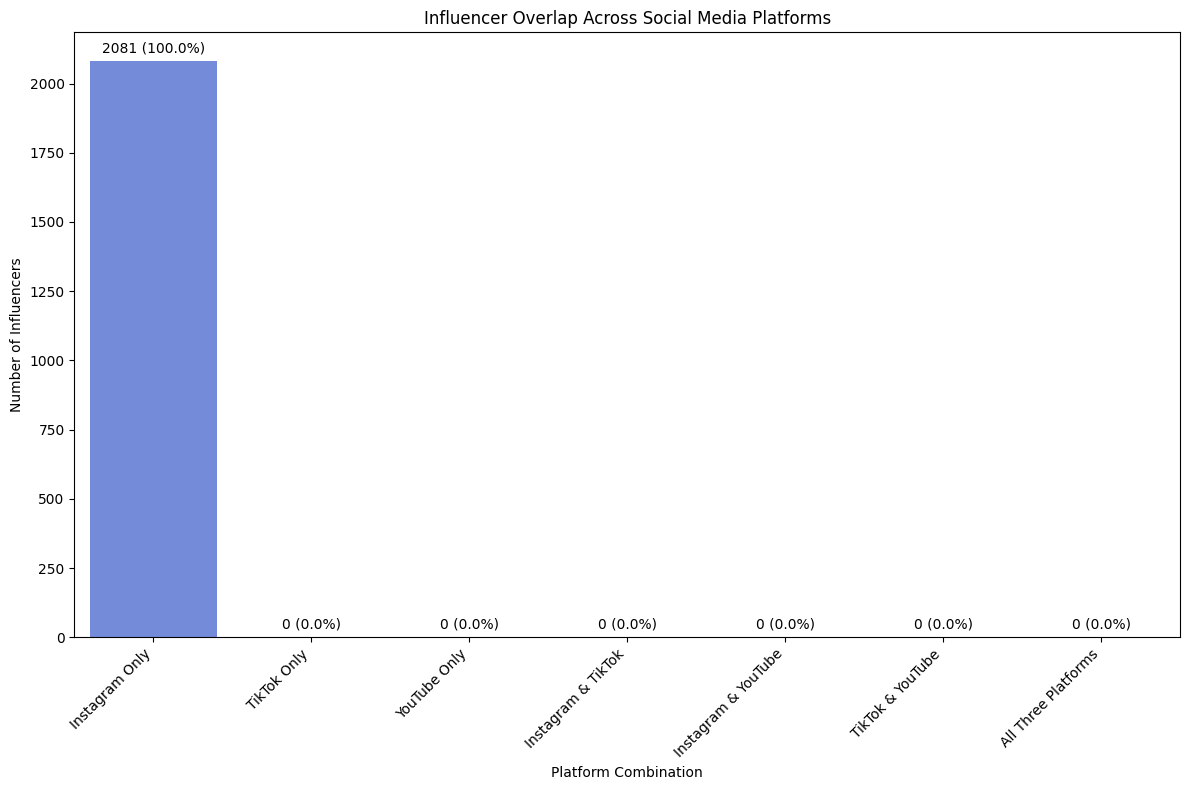


--- Examples of Overlapping Influencers ---

No influencers found for: Influencers on All Three Platforms

No influencers found for: Influencers on Instagram & TikTok ONLY

No influencers found for: Influencers on Instagram & YouTube ONLY

No influencers found for: Influencers on TikTok & YouTube ONLY

--- Influencer Overlap Analysis Complete ---


In [5]:
# --- Helper Function to Standardize Influencer Names ---
def standardize_name(name_series):
    """
    Cleans and standardizes influencer names/handles for matching.
    Converts to lowercase, removes non-alphanumeric characters.
    Handles potential NaN values.
    """
    if not pd.api.types.is_string_dtype(name_series):
        name_series = name_series.astype(str)

    # Convert to lowercase, remove non-alphanumeric (except space), then strip spaces
    cleaned_names = name_series.str.lower().str.replace(r'[^a-z0-9\s]', '', regex=True).str.strip()
    # Replace multiple spaces with single space, then remove all spaces
    cleaned_names = cleaned_names.str.replace(r'\s+', '', regex=True)

    # Replace empty strings or "nan" strings with actual NaN
    cleaned_names = cleaned_names.replace({'': np.nan, 'nan': np.nan})

    return cleaned_names

# --- Main Analysis Function for Influencer Overlap ---
def analyze_influencer_overlap(
    insta_df, tiktok_df, youtube_df,
    insta_name_col='instagram_name',  # <--- Update to your Instagram's primary name/handle column
    tiktok_name_col='name',            # <--- Update to your TikTok's primary name/handle column
    yt_name_col='name'                 # <--- Update to your YouTube's primary name/handle column
):
    """
    Identifies and visualizes the overlap of influencers across Instagram, TikTok, and YouTube.

    Args:
        insta_df (pd.DataFrame): DataFrame containing Instagram influencer data.
        tiktok_df (pd.DataFrame): DataFrame containing TikTok influencer data.
        youtube_df (pd.DataFrame): DataFrame containing YouTube influencer data.
        insta_name_col (str): The column name in insta_df containing influencer names/handles.
        tiktok_name_col (str): The column name in tiktok_df containing influencer names/handles.
        yt_name_col (str): The column name in youtube_df containing influencer names/handles.
    """
    print("--- Starting Influencer Overlap Analysis ---")

    platform_names = ['Instagram', 'TikTok', 'YouTube']
    dataframes = {
        'Instagram': insta_df,
        'TikTok': tiktok_df,
        'YouTube': youtube_df
    }
    name_cols = {
        'Instagram': insta_name_col,
        'TikTok': tiktok_name_col,
        'YouTube': yt_name_col
    }

    standardized_sets = {}
    original_names_map = {} # To map standardized name back to original names for examples

    for platform in platform_names:
        df = dataframes[platform]
        name_col = name_cols[platform]

        if df is None:
            print(f"Skipping {platform}: DataFrame is None.")
            standardized_sets[platform] = set() # Empty set if no data
            continue

        if name_col not in df.columns:
            print(f"Skipping {platform}: Column '{name_col}' not found. Check mapping.")
            standardized_sets[platform] = set() # Empty set if column not found
            continue

        # Create a temporary DataFrame for standardization to keep original names
        temp_df = df[[name_col]].dropna().drop_duplicates().copy()
        temp_df['standardized_name'] = standardize_name(temp_df[name_col])

        # Drop rows where standardization resulted in NaN (e.g., empty strings)
        temp_df.dropna(subset=['standardized_name'], inplace=True)

        standardized_sets[platform] = set(temp_df['standardized_name'])

        # Store a mapping from standardized name to an original name for display later
        for _, row in temp_df.iterrows():
            if row['standardized_name'] not in original_names_map:
                original_names_map[row['standardized_name']] = {}
            original_names_map[row['standardized_name']][platform] = row[name_col]


        print(f"\n{platform}: Found {len(standardized_sets[platform])} unique standardized influencers.")

    insta_set = standardized_sets.get('Instagram', set())
    tiktok_set = standardized_sets.get('TikTok', set())
    youtube_set = standardized_sets.get('YouTube', set())

    # --- Calculate Overlaps ---
    only_insta = insta_set - tiktok_set - youtube_set
    only_tiktok = tiktok_set - insta_set - youtube_set
    only_youtube = youtube_set - insta_set - tiktok_set

    insta_tiktok_only = (insta_set & tiktok_set) - youtube_set
    insta_youtube_only = (insta_set & youtube_set) - tiktok_set
    tiktok_youtube_only = (tiktok_set & youtube_set) - insta_set

    all_three = insta_set & tiktok_set & youtube_set

    total_unique_influencers = len(insta_set | tiktok_set | youtube_set) # Union of all sets

    print("\n--- Overlap Summary ---")
    print(f"Total Unique Influencers Across All Platforms: {total_unique_influencers}")
    print(f"Influencers on Instagram ONLY: {len(only_insta)}")
    print(f"Influencers on TikTok ONLY: {len(only_tiktok)}")
    print(f"Influencers on YouTube ONLY: {len(only_youtube)}")
    print(f"Influencers on Instagram & TikTok ONLY: {len(insta_tiktok_only)}")
    print(f"Influencers on Instagram & YouTube ONLY: {len(insta_youtube_only)}")
    print(f"Influencers on TikTok & YouTube ONLY: {len(tiktok_youtube_only)}")
    print(f"Influencers on ALL THREE Platforms: {len(all_three)}")

    # --- Prepare Data for Visualization ---
    overlap_counts = {
        'Instagram Only': len(only_insta),
        'TikTok Only': len(only_tiktok),
        'YouTube Only': len(only_youtube),
        'Instagram & TikTok': len(insta_tiktok_only),
        'Instagram & YouTube': len(insta_youtube_only),
        'TikTok & YouTube': len(tiktok_youtube_only),
        'All Three Platforms': len(all_three)
    }

    plot_data = pd.DataFrame(list(overlap_counts.items()), columns=['Platform Combination', 'Count'])
    plot_data['Percentage'] = (plot_data['Count'] / total_unique_influencers) * 100

    # Sort for better visualization
    plot_data = plot_data.sort_values(by='Count', ascending=False)

    # --- Visualization ---
    if total_unique_influencers > 0:
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Platform Combination', y='Count', data=plot_data, palette='coolwarm')
        plt.title('Influencer Overlap Across Social Media Platforms')
        plt.xlabel('Platform Combination')
        plt.ylabel('Number of Influencers')
        plt.xticks(rotation=45, ha='right')
        # Add count and percentage labels on bars
        for index, row in plot_data.iterrows():
            plt.text(index, row['Count'] + max(plot_data['Count']) * 0.01,
                     f"{row['Count']} ({row['Percentage']:.1f}%)",
                     color='black', ha="center", va='bottom')
        plt.tight_layout()
        plt.show()
    else:
        print("No unique influencers found across any platforms for visualization.")

    # --- Examples of Overlapping Influencers ---
    print("\n--- Examples of Overlapping Influencers ---")

    def print_examples(overlap_set, title):
        if overlap_set:
            print(f"\n{title}:")
            count = 0
            for s_name in list(overlap_set):
                if count >= 5: break # Print up to 5 examples
                original_names = original_names_map.get(s_name, {})
                print(f"  - Standardized: '{s_name}'")
                for p, o_name in original_names.items():
                    print(f"    - {p}: '{o_name}'")
                count += 1
        else:
            print(f"\nNo influencers found for: {title}")

    print_examples(all_three, "Influencers on All Three Platforms")
    print_examples(insta_tiktok_only, "Influencers on Instagram & TikTok ONLY")
    print_examples(insta_youtube_only, "Influencers on Instagram & YouTube ONLY")
    print_examples(tiktok_youtube_only, "Influencers on TikTok & YouTube ONLY")

    print("\n--- Influencer Overlap Analysis Complete ---")


# --- EXAMPLE DATA LOADING (REPLACE WITH YOUR ACTUAL DATA) ---
# IMPORTANT: Make sure your CSV files are in the same directory as this script,
# or provide the full path (e.g., 'C:/Users/YourUser/Desktop/instagram_data.csv').

try:
    # Ensure these columns exist in your Instagram data
    insta_df = pd.read_csv('./Clean_Data/merged_instagram_data_cleaned.csv')
    print("Instagram data loaded.")
except FileNotFoundError:
    print("instagram_data.csv not found. Please check the file path.")
    insta_df = None

try:
    # Ensure these columns exist in your TikTok data
    tiktok_df = pd.read_csv('./Clean_Data/merged_tiktok_data_cleaned.csv')
    print("TikTok data loaded.")
except FileNotFoundError:
    print("tiktok_data.csv not found. Please check the file path.")
    tiktok_df = None

try:
    # Ensure these columns exist in your YouTube data
    youtube_df = pd.read_csv('./Clean_Data/merged_youtube_data_cleaned.csv')
    print("YouTube data loaded.")
except FileNotFoundError:
    print("youtube_data.csv not found. Please check the file path.")
    youtube_df = None


# --- CALL THE INFLUENCER OVERLAP ANALYSIS FUNCTION ---
# VERY IMPORTANT:
# Update the 'insta_name_col', 'tiktok_name_col', and 'yt_name_col'
# to the EXACT column names in YOUR CSV files that contain the influencer's
# name or unique handle used for matching.
#
# Common column names might be: 'name', 'influencer_name', 'username', 'instagram_name', 'tiktok_handle', 'youtube_channel_name'
analyze_influencer_overlap(
    insta_df=insta_df,
    tiktok_df=tiktok_df,
    youtube_df=youtube_df,
    insta_name_col='instagram_name', # <--- CUSTOMIZE THIS based on your Instagram data
    tiktok_name_col='name',           # <--- CUSTOMIZE THIS based on your TikTok data
    yt_name_col='name'                # <--- CUSTOMIZE THIS based on your YouTube data
)